# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from collections import namedtuple


os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
conf.set("spark.executor.memory", "4g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

# conf.set("spark.dynamicAllocation.enabled", "true")
# conf.set("spark.shuffle.service.enabled", "true")
# conf.set("spark.dynamicAllocation.initialExecutors", 2)
# conf.set("spark.dynamicAllocation.maxExecutors", 2)

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [5]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2020-02-04 22:33 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2020-02-04 22:33 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2020-02-04 22:33 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2020-02-04 22:33 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2020-02-04 22:33 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2020-02-04 22:33 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2020-02-04 22:34 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2020-02-04 22:34 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2020-02-04 22:34 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [52]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [53]:
ratings = sc.textFile(RATINGS_PATH)

In [54]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [55]:
ratings.getNumPartitions()

5

In [56]:
Rating = namedtuple("Rating", ["user_id", "movie_id", "rating", "timestamp"])

In [57]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [58]:
ratings.count()

25000095

Количество пользователей

In [59]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 33.4 ms, sys: 2.43 ms, total: 35.8 ms
Wall time: 2min 31s


162541

Сохраним датасет в память

In [60]:
ratings = ratings.persist()

In [61]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 38.2 ms, sys: 8.76 ms, total: 47 ms
Wall time: 3min 59s


162541

Количество фильмов

In [62]:
ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [16]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [17]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (188573, (5.0, ['188573', 'Judy (2014)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [18]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [20]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [21]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [22]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

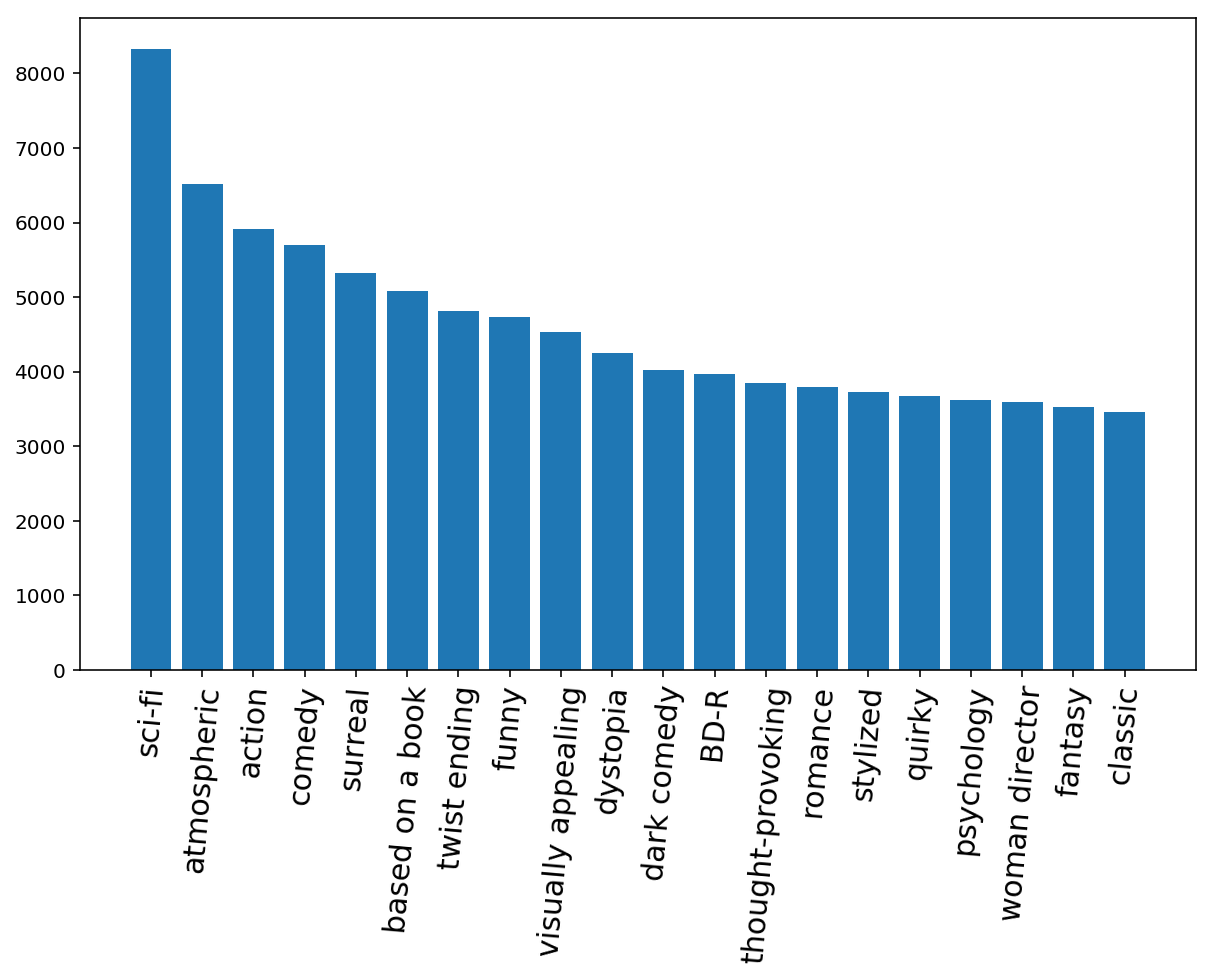

In [23]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Определим Movie, Tag

In [63]:
ratings.take(5)

[Rating(user_id=1, movie_id=296, rating=5.0, timestamp=1147880044),
 Rating(user_id=1, movie_id=306, rating=3.5, timestamp=1147868817),
 Rating(user_id=1, movie_id=307, rating=5.0, timestamp=1147868828),
 Rating(user_id=1, movie_id=665, rating=5.0, timestamp=1147878820),
 Rating(user_id=1, movie_id=899, rating=3.5, timestamp=1147868510)]

In [38]:
Movie = namedtuple('Movie', ['movie_id', 'title', 'genres'])

movies = sc.textFile(MOVIES_PATH)

header = movies.first()
movies = movies \
  .filter(lambda s: s != header) \
  .map(lambda s: s.split(',')) \
  .map(lambda arr: Movie(int(arr[0]) ,arr[1], arr[2].split('|')))

movies.persist()

movies.take(5)


[Movie(movie_id=1, title='Toy Story (1995)', genres=['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']),
 Movie(movie_id=2, title='Jumanji (1995)', genres=['Adventure', 'Children', 'Fantasy']),
 Movie(movie_id=3, title='Grumpier Old Men (1995)', genres=['Comedy', 'Romance']),
 Movie(movie_id=4, title='Waiting to Exhale (1995)', genres=['Comedy', 'Drama', 'Romance']),
 Movie(movie_id=5, title='Father of the Bride Part II (1995)', genres=['Comedy'])]

In [46]:
Tag = namedtuple('Tag', ["user_id", "movie_id", "tag", "timestamp"])

tags = sc.textFile(TAGS_PATH)

header = tags.first()
tags = tags \
  .filter(lambda s: s != header) \
  .map(lambda s: s.split(',')) \
  .map(lambda arr: Tag(int(arr[0]), int(arr[1]), arr[2], arr[3]))

tags.persist()
tags.take(5)

[Tag(user_id=3, movie_id=260, tag='classic', timestamp='1439472355'),
 Tag(user_id=3, movie_id=260, tag='sci-fi', timestamp='1439472256'),
 Tag(user_id=4, movie_id=1732, tag='dark comedy', timestamp='1573943598'),
 Tag(user_id=4, movie_id=1732, tag='great dialogue', timestamp='1573943604'),
 Tag(user_id=4, movie_id=7569, tag="so bad it's good", timestamp='1573943455')]

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [131]:
%%time

movie_names = movies \
  .map(lambda movie: (movie.movie_id, movie.title))

movie_occurrency = ratings \
  .map(lambda r: (r.movie_id, 1)) \
  .reduceByKey(lambda a, b: a + b) \
  .join(movie_names) \
  .map(lambda id_info: id_info[1]) \
  .map(lambda occurrency_movie: (occurrency_movie[1], occurrency_movie[0])) \
  .sortBy(lambda movie_occurrency: movie_occurrency[1], ascending=False) \

movie_occurrency.take(10)

CPU times: user 48.3 ms, sys: 14.3 ms, total: 62.6 ms
Wall time: 1min 8s


[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [90]:
ratings_5_only = ratings.filter(lambda rating: abs(rating.rating - 5.) < 1e-5)

ratings_5_only \
  .map(lambda r: (r.movie_id, 1)) \
  .reduceByKey(lambda a, b: a + b) \
  .join(movie_names) \
  .map(lambda id_info: id_info[1]) \
  .map(lambda occurrency_movie: (occurrency_movie[1], occurrency_movie[0])) \
  .sortBy(lambda movie_occurrency: movie_occurrency[1], ascending=False) \
  .take(10)

[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

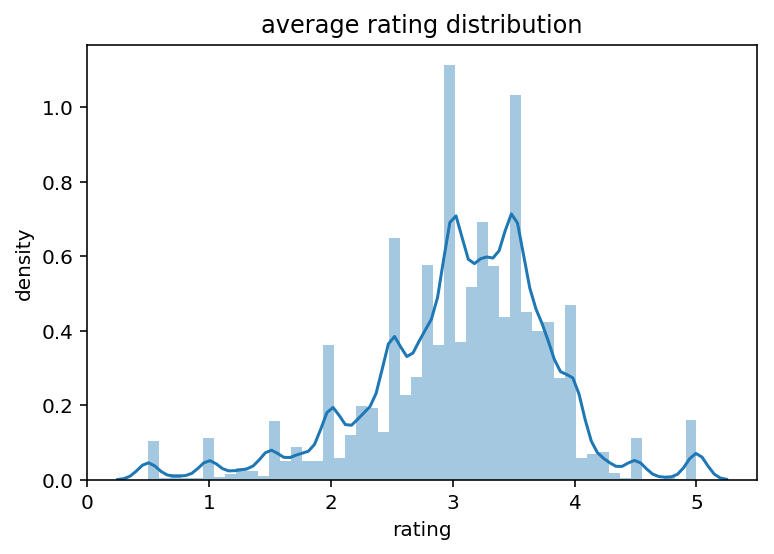

In [129]:
avg_ratings = movie_avg_rating \
  .map(lambda id_rating: id_rating[1]) \
  .collect()

sns.distplot(avg_ratings)
plt.title('average rating distribution')
plt.ylabel('density')
plt.xlabel('rating')
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

TypeError: cannot perform reduce with flexible type

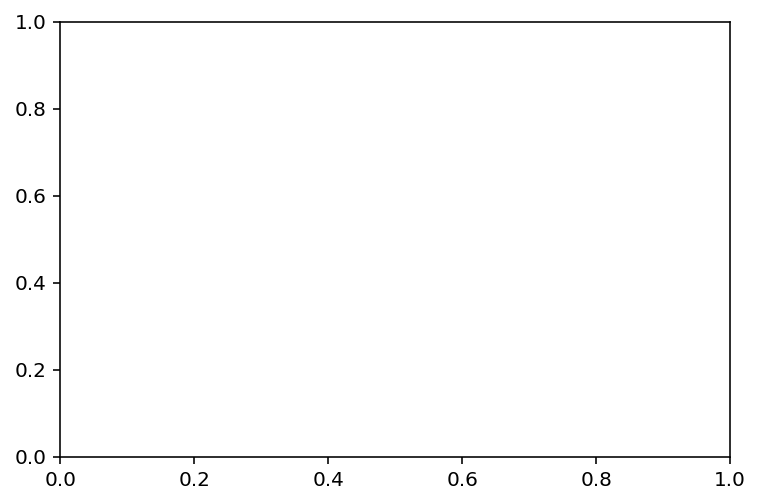

In [132]:
occurrencies = movie_occurrency \
  .map(lambda movie_occurrency: movie_occurrency) \
  .collect()

sns.distplot(occurrencies)
plt.title("movie occurrency in ratings")
plt.ylabel("density")
plt.xlabel("occurrency")
plt.show()

на всякий случай построю рапределение логарифма

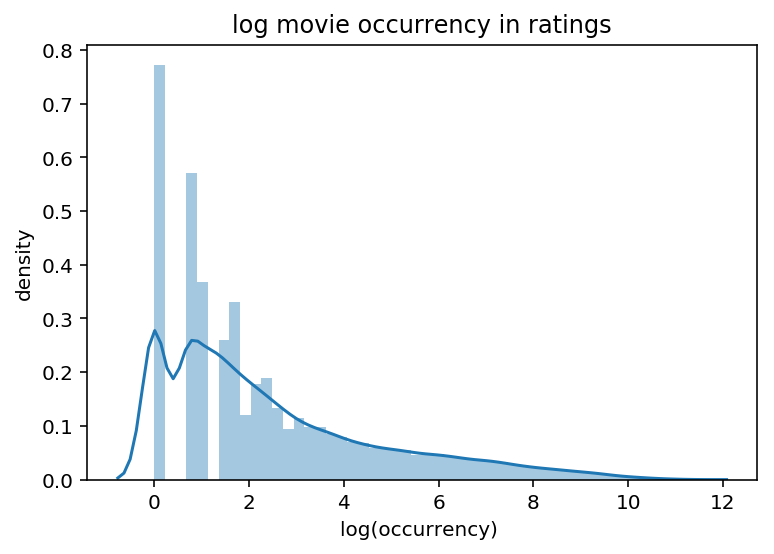

In [110]:
import numpy as np

sns.distplot(np.log(occurrencies))
plt.title("log movie occurrency in ratings")
plt.ylabel("density")
plt.xlabel("log(occurrency) ")
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

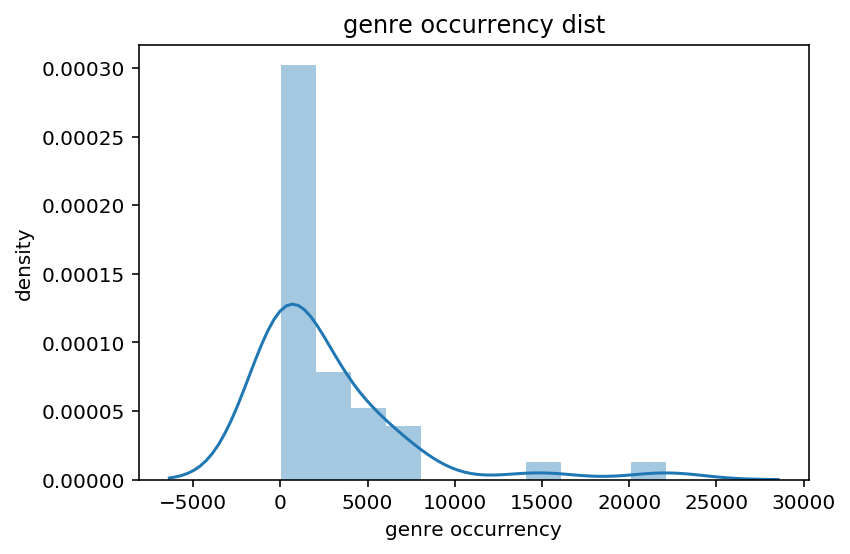

In [144]:
genre_counts = movies \
  .flatMap(lambda movie: [(genre, movie.movie_id) for genre in movie.genres]) \
  .distinct() \
  .map(lambda genre_movie: (genre_movie[0], 1)) \
  .reduceByKey(lambda a, b: a+b)

counts = genre_counts \
  .map(lambda genre_count: genre_count[1]) \
  .collect()

popular_counts = [cnt for cnt in counts if cnt > 50]

sns.distplot(popular_counts)
plt.title('genre occurrency dist')
plt.ylabel('density')
plt.xlabel('genre occurrency')
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################